In [1]:
import retro
import argparse
import wandb
import pathlib
import pickle
import numpy as np
import imageio
import pickle
import os
import shutil
import glob
import tensorflow as tf
import matplotlib.pyplot as plt
import gzip
from rrt import RRT
from tqdm import tqdm

In [2]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   try:
#     for gpu in gpus:
#       tf.config.experimental.set_memory_growth(gpu, True)
#   except RuntimeError as e:
#     print(e)

In [3]:
# wandb setup, execute first to log into wandb
run = wandb.init(
    project="turbocharger",
    job_type='training')

wandb: Currently logged in as: kchang44 (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [4]:

# get the rom and put it into retro's dir
tree_run = run.use_artifact("SuperMarioWorld-Snes-rrt_play:v4")
tree_dir = tree_run.download()

wandb: Downloading large artifact SuperMarioWorld-Snes-rrt_play:v4, 268.45MB. 1 files... Done. 0:0:0


In [5]:
with gzip.open(f"{tree_dir}/tree.pickle.gz", "rb") as f:
    tree = pickle.load(f)

In [6]:
parent = dict()
edges = list()
weights = list()
for source, action, target in tree.edges:
    parent[target] = (source, tree.unpack_action(action), target)
    edges.append((source, tree.unpack_action(action), target))
    weights.append(len(tree.unpack_action(action)))
weights = np.array(weights)
edges = np.array(edges, dtype='object')

In [6]:
# Pick an edge according to the edge_weights, and then pick a point on the edge.
# Pick from another edge X number of actions backwards in time from this action another point
# Create a path backwards by traversing through the sources of the initial edge back to the second point
# Record emulator RAM capture at the end of this path, the beginning of this path and button press that was done at the start of the path (this is 3 items total!)
# Save this out as a triplet: (ram_current, current_button, ram_goal)
# rand_edge = np.random.choice(edge_weights)
print(weights.shape)


(3000,)


In [7]:
# len(parent.keys())

In [6]:
# source, action, target
# Choose inputs outputs

def generate_timeline(length=100):
    goal_branch = edges[np.random.choice(np.arange(len(edges)), p=weights/np.sum(weights))]
    goal_point = int(np.random.uniform(0, len(goal_branch[1])))
#     print(f"Goal point: {goal_point}")
#     print(f"len of goal branch: {len(goal_branch[1])}")
    # the point where we want to start from where the end point is selected_point
    current_point = goal_point 
    # Now we walk backwards from this edge
    steps_remaining = length
    current_branch = goal_branch

    # Eats off the remaining steps of the goal branch
    while steps_remaining > 0: 
#         print(f">>> steps remaining: {steps_remaining}")
#         print(f">>> length of current branch: {len(current_branch[1])}")
#         print(f">>> current_point: {current_point}")
        # len of the current branch cannot fulfill steps remaining
    #     if(steps_remaining > len(current_branch[1])):
        # Where we are is greater than the number of steps remaining on this branch
        if(current_point < steps_remaining):
#             print(">>> Moving up one branch")
            # remove the current branch's length from the steps remaining
    #         steps_remaining -= len(current_branch[1]) 
            steps_remaining -= current_point
            #  go up one branch
            try:
                current_branch = parent[current_branch[0]]
            except KeyError as k:
                print("Parent not found, likely ended up at root")
                break
            # set the current branch to the end of this branch
            current_point = len(current_branch[1])
        else:
            # len of the current branch can fulfill steps remaining
#             print(">>> len of the current branch can fulfill steps remaining")
            # walk back the remaning number of steps on this branch
            current_point -= steps_remaining
#             print(f">>> After removing {steps_remaining} steps from the current point, our current point is {current_point}")
            steps_remaining = 0

    # Eventially we want to collect three things, the RAM at the start of this path, the RAM at the end, and the button press done at the RAM at the start of the path
    A = (goal_branch, goal_point)
    B = (current_branch, current_point)
    return A, B

# Testing do not use A or B from here
A, B = generate_timeline(50)
print(A[1])
print(B[1])

96
46


In [7]:
# A is a tuple of a goal branch, and a point on there. A[0] is the goal branch
len(A[0])
# A[0][1] is the action array
print(len(A[0][1]))
print(type(A[0][1]))
# A[0][1][A[1]] is the action at the goal_point A[1] recorded in the edge
print(A[0][1][A[1]])
# A[0][0] is a tuple of the vectorized ram and state. len(A[0][0][0]) is the vectorized ram
print(len(A[0][0][0]))
# The thing we want is the state at A[0][0][1] to load into retro
# We also want to play actions starting from state A[0][0][1], starting with action A[0][1][0] (the first action in this branch). This will be played to A[0][1][A[1]], all actions along timeline are played.
# Once it is played, we extract ram from the emulator at this moment. Also extract out the action at this moment too (remember it is A[0][1][A[1]])

# To get the goal ram, we get B[0][0][1]'s state, and the actions starting from B[0][1][0] (the first action in this branch) will be inputted into em until it gets to B[0][1][B[1]], the selected point.
# Once the emulator is played to this point, we extract out ram. 
# Save this all out as a triple (starting_ram, action_at_start, ending_ram)

185
<class 'numpy.ndarray'>
[0 0 1 1 1 1 1 0 0 0 1 0]
128


In [12]:
def generate_samples(n_samples=1000, steps_backwards=50):
    # Turn on an env
    env = retro.make(
        game="SuperMarioWorld-Snes",
        state=None,
        # bk2s can contain any button presses, so allow everything
        use_restricted_actions=retro.Actions.ALL
    )
    starting_rams = list()
    goal_rams = list()
    actions = list()
    for i in tqdm(range(n_samples)):
        # make ourselves a timeline from the rrt tree:
        A, B = generate_timeline(50)
        # Start game at initial state A[0][0][1]
        env.initial_state = A[0][0][1]
        env.reset()
        # Reset for retro quirkiness... then reload A[0][0][1]
        env.em.set_state(A[0][0][1])
        # For the actions in the start branch, sliced from index 0 to the current_point
        for action in A[0][1][0:A[1]]:
            # execute them in the emulator
            env.step(action)
        # Now we have rewound time back to this point in the branch, extract out the ram
        starting_ram = env.get_ram()[0:8192]
        # Just for readability, save out the action at this point in time
        action_at_start = A[0][1][A[1]]

        # Load the goal state
        env.reset()
        env.em.set_state(B[0][0][1])
        # For the actions in the goal branch, sliced from index 0 to the goal_point
        for action in B[0][1][0:B[1]]:
            # execute them in the emulator
            env.step(action)
        # Now we have rewound time back to this point in the branch, extract out the ram
        goal_ram = env.get_ram()[0:8192]
        
        starting_rams.append(starting_ram)
        goal_rams.append(goal_ram)
        actions.append(action_at_start)
    env.close()
    return np.array(starting_rams), np.array(goal_rams), np.array(actions)

# cleanup
# env.close()

In [10]:
# print(len(starting_ram))
# print(len(goal_ram))
print(np.array_equal(starting_ram, goal_ram))
print(action_at_start)

NameError: name 'starting_ram' is not defined

In [13]:
# Cause GPU memory growth is pain
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [14]:
# Make training data
train = generate_samples(1000, steps_backwards=10)
test = generate_samples(1000, steps_backwards=10)

 20%|█▉        | 198/1000 [00:48<03:23,  3.93it/s]

Parent not found, likely ended up at root


 28%|██▊       | 276/1000 [01:10<02:41,  4.49it/s]

Parent not found, likely ended up at root


 30%|███       | 302/1000 [01:15<02:34,  4.52it/s]

Parent not found, likely ended up at root


 90%|████████▉ | 896/1000 [03:54<00:19,  5.38it/s]

Parent not found, likely ended up at root


 95%|█████████▍| 947/1000 [04:10<00:15,  3.51it/s]

Parent not found, likely ended up at root


100%|██████████| 1000/1000 [04:27<00:00,  3.74it/s]


In [16]:
import pickle
with open('train.pickle', 'wb') as f:
    pickle.dump(train, f)
with open('test.pickle', 'wb') as f:
    pickle.dump(test, f)

In [7]:
import pickle
with open('train.pickle', 'rb') as f:
    train = pickle.load(f)
with open('test.pickle', 'rb') as f:
    test = pickle.load(f)

In [8]:
# Goal RAM Encoder
mem_shape = train[0][0].shape
buttons_shape = train[0][2].shape

# embed_mem model latent size no idea if this is OK but let's leave it be for now
flat_size = 64

# Single linear layer, no activation, with l2 regularization
ram_input_layer = tf.keras.layers.Input(shape=(mem_shape))
x = ram_input_layer
x = tf.keras.layers.Dense(
    flat_size, 
    kernel_regularizer=None, 
    activation='relu',
    name="mem_embedding_layer1",
    trainable=True
    )(x)

x = tf.keras.layers.Dense(
    128, 
    kernel_regularizer=None, 
    activation='relu',
    name="mem_embedding_layer2")(x)

x = tf.keras.layers.Dense(
    flat_size, 
    kernel_regularizer=None, 
    name="mem_embedding_layer3")(x)

embedding = tf.keras.layers.Flatten()(x)

mem_encoder = tf.keras.Model(ram_input_layer, embedding, name="Mem_Encoder")

mem_encoder.compile()
mem_encoder.summary()

Model: "Mem_Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8192)]            0         
_________________________________________________________________
mem_embedding_layer1 (Dense) (None, 64)                524352    
_________________________________________________________________
mem_embedding_layer2 (Dense) (None, 128)               8320      
_________________________________________________________________
mem_embedding_layer3 (Dense) (None, 64)                8256      
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
Total params: 540,928
Trainable params: 540,928
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Mem Decoder
mem_shape = train[0][0].shape
buttons_shape = train[0][2].shape

print(mem_shape)
# embed_mem model latent size no idea if this is OK but let's leave it be for now

# Single linear layer, no activation, with l2 regularization
x = embedding_input = tf.keras.layers.Input(shape=(flat_size))

x =  tf.keras.layers.Dense(
    flat_size*2, 
    kernel_regularizer=None, 
    activation='relu',
    name="mem_decoding_layer2")(x)

x =  tf.keras.layers.Dense(
    flat_size*3, 
    kernel_regularizer=None, 
    activation='relu',
    name="mem_decoding_layer3")(x)

uncompressed =  tf.keras.layers.Dense(
    mem_shape[0], 
    kernel_regularizer=None, 
    name="mem_decoding_layer4")(x)

mem_decoder = tf.keras.Model(embedding_input, uncompressed, name="Mem_Decoder_Model")

mem_decoder.compile()
mem_decoder.summary()

(8192,)
Model: "Mem_Decoder_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
mem_decoding_layer2 (Dense)  (None, 128)               8320      
_________________________________________________________________
mem_decoding_layer3 (Dense)  (None, 192)               24768     
_________________________________________________________________
mem_decoding_layer4 (Dense)  (None, 8192)              1581056   
Total params: 1,614,144
Trainable params: 1,614,144
Non-trainable params: 0
_________________________________________________________________


In [10]:
# MemVec MemVec to Policy model

current_vec = tf.keras.layers.Input(shape=(flat_size))
goal_vec = tf.keras.layers.Input(shape=(flat_size))

# Put the current and goal mem vec together
x = tf.keras.layers.Concatenate()([current_vec, goal_vec])
# Policy to condense this down to 12 probabilities
for i in range(2):
    x = tf.keras.layers.Dense(
        256, 
        activation='tanh', 
        kernel_regularizer='l2')(x)
    
buttons_layers = tf.keras.layers.Dense(12, 
    activation='sigmoid')(x)

buttons_model = tf.keras.Model([current_vec, goal_vec], buttons_layers, name="Goal_and_Current_Mem_Embeddings_to_Buttons")

buttons_model.compile()
buttons_model.summary()

Model: "Goal_and_Current_Mem_Embeddings_to_Buttons"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 64)]         0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 128)          0           input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          3302

In [11]:
current_mem_inputs = tf.keras.layers.Input(shape=(mem_shape))
goal_mem_inputs = tf.keras.layers.Input(shape=(mem_shape))

current_encoded = mem_encoder(current_mem_inputs)
goal_decoded = mem_decoder(current_encoded)

mem2mem = tf.keras.Model(current_mem_inputs, goal_decoded, name="mem2mem")
mem2mem.compile(loss="mse", metrics=["mae"], optimizer=tf.keras.optimizers.Adam(lr=0.001))
mem2mem.summary()

Model: "mem2mem"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 8192)]            0         
_________________________________________________________________
Mem_Encoder (Functional)     (None, 64)                540928    
_________________________________________________________________
Mem_Decoder_Model (Functiona (None, 8192)              1614144   
Total params: 2,155,072
Trainable params: 2,155,072
Non-trainable params: 0
_________________________________________________________________


In [12]:
# All together model
print(mem_shape)
current_mem_inputs = tf.keras.layers.Input(shape=(mem_shape), name="current_mem")
goal_mem_inputs = tf.keras.layers.Input(shape=(mem_shape), name="goal_mem")

goal_encoded = mem_encoder(goal_mem_inputs)
current_encoded = mem_encoder(current_mem_inputs)

predict_buttons = buttons_model([current_encoded, goal_encoded])
memmem2buttons = tf.keras.Model([current_mem_inputs, goal_mem_inputs], predict_buttons)

memmem2buttons.compile(loss="binary_crossentropy", metrics=["binary_accuracy"], optimizer=tf.keras.optimizers.Adam(lr=0.001))
memmem2buttons.summary()

(8192,)
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
current_mem (InputLayer)        [(None, 8192)]       0                                            
__________________________________________________________________________________________________
goal_mem (InputLayer)           [(None, 8192)]       0                                            
__________________________________________________________________________________________________
Mem_Encoder (Functional)        (None, 64)           540928      goal_mem[0][0]                   
                                                                 current_mem[0][0]                
__________________________________________________________________________________________________
Goal_and_Current_Mem_Embeddings (None, 12)           101900      Mem_Encoder[2]

In [15]:
X = train[0]
Y = train[1]
# Autoencode back to current memory
mem2mem_result = mem2mem.fit(X, 
                             X, 
#                              validation_data=([test_inputs[0], test_inputs[1]], test_outputs),
                             epochs=100, 
                             batch_size=64, 
                             verbose=1, 
                             callbacks=None)
# mem2mem_result = mem2mem.fit(X, 
#                              Y, 
# #                              validation_data=([test_inputs[0], test_inputs[1]], test_outputs),
#                              epochs=100, 
#                              batch_size=64, 
#                              verbose=1, 
#                              callbacks=None)

Epoch 1/100
16/16 [==============================] - 0s 2ms/step - loss: 1666.9685 - mae: 24.1549
Epoch 2/100
16/16 [==============================] - 0s 2ms/step - loss: 189.4891 - mae: 7.1330
Epoch 3/100
16/16 [==============================] - 0s 2ms/step - loss: 132.7726 - mae: 3.8747
Epoch 4/100
16/16 [==============================] - 0s 2ms/step - loss: 121.9045 - mae: 2.9261
Epoch 5/100
16/16 [==============================] - 0s 2ms/step - loss: 108.8998 - mae: 2.8111
Epoch 6/100
16/16 [==============================] - 0s 2ms/step - loss: 78.6486 - mae: 2.3570
Epoch 7/100
16/16 [==============================] - 0s 2ms/step - loss: 66.6533 - mae: 1.8191
Epoch 8/100
16/16 [==============================] - 0s 2ms/step - loss: 64.7721 - mae: 1.5844
Epoch 9/100
16/16 [==============================] - 0s 2ms/step - loss: 63.7412 - mae: 1.4567
Epoch 10/100
16/16 [==============================] - 0s 2ms/step - loss: 63.0479 - mae: 1.3959
Epoch 11/100
16/16 [======================

In [18]:
# Fit?
# Idea: just predict without a goal
memmem_train = [train[0], train[0]]
memmem_test = train[2]
result = memmem2buttons.fit(memmem_train, 
                             memmem_test, 
#                              validation_data=([test_inputs[0], test_inputs[1]], test_outputs),
                             epochs=20, 
                             batch_size=256, 
                             verbose=1, 
                             callbacks=None)

Epoch 1/20
4/4 [==============================] - 0s 3ms/step - loss: 0.6652 - binary_accuracy: 0.5808
Epoch 2/20
4/4 [==============================] - 0s 3ms/step - loss: 0.6629 - binary_accuracy: 0.5842
Epoch 3/20
4/4 [==============================] - 0s 3ms/step - loss: 0.6607 - binary_accuracy: 0.5790
Epoch 4/20
4/4 [==============================] - 0s 3ms/step - loss: 0.6584 - binary_accuracy: 0.5782
Epoch 5/20
4/4 [==============================] - 0s 3ms/step - loss: 0.6566 - binary_accuracy: 0.5815
Epoch 6/20
4/4 [==============================] - 0s 3ms/step - loss: 0.6564 - binary_accuracy: 0.5803
Epoch 7/20
4/4 [==============================] - 0s 3ms/step - loss: 0.6546 - binary_accuracy: 0.5800
Epoch 8/20
4/4 [==============================] - 0s 3ms/step - loss: 0.6535 - binary_accuracy: 0.5723
Epoch 9/20
4/4 [==============================] - 0s 3ms/step - loss: 0.6510 - binary_accuracy: 0.5827
Epoch 10/20
4/4 [==============================] - 0s 2ms/step - loss: 0.

In [19]:
# Train and test forwards and backwards. 
memmem2buttons.evaluate([test[0], test[1]], test[2])
memmem2buttons.evaluate([test[0], test[0]], test[2])
memmem2buttons.evaluate([test[0], test[1]], test[2][::-1])

memmem2buttons.evaluate([train[0], train[1]], train[2])
memmem2buttons.evaluate([train[0], train[0]], train[2])
memmem2buttons.evaluate([train[0], train[1]], train[2][::-1])

32/32 [==============================] - 0s 1ms/step - loss: 0.6361 - binary_accuracy: 0.5828


[0.6360771059989929, 0.5828332901000977]

In [20]:
encoded_test_mems = mem_encoder(X)

In [21]:
encoded_goal_test_mems = mem_encoder(Y)

In [22]:
predicted_buttons = buttons_model.predict([encoded_test_mems, encoded_goal_test_mems])

In [23]:
a = memmem_test.mean(0)

In [24]:
b = predicted_buttons.mean(0)

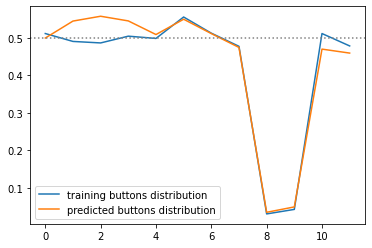

In [25]:
import matplotlib.pyplot as plt

plt.plot(a, label="training buttons distribution")
plt.plot(b, label="predicted buttons distribution")
plt.axhline(0.5, color='gray', linestyle="dotted")
plt.legend()

In [26]:
memmem2buttons.save("./buttons_model")
mem_encoder.save("./mem_encoder")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./buttons_model/assets
INFO:tensorflow:Assets written to: ./mem_encoder/assets


In [27]:
artifact = wandb.Artifact('models', type='model')
artifact.add_dir('buttons_model', name='buttons_model')
artifact.add_dir('embed_mem_model', name='embed_mem_model')
run.log_artifact(artifact)

wandb: Adding directory to artifact (./buttons_model)... Done. 0.1s
wandb: Adding directory to artifact (./embed_mem_model)... Done. 0.1s
